<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/1_3_MNIST_deep_dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# Plot 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.title("Train vs Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

[MYCODE] dataset 리팩토링

- dataset 중복코드 제거
- trainset 생성
- testset 생성

In [19]:
transform = transforms.ToTensor()

def get_dataset(train= True, download=True):
    trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

batch_size = 256
def get_loader(dataset, suffle=True):
    trainloader = torch.utils.data.DataLoader(
      trainset,
      batch_size=batch_size,
      shuffle=suffle
)


trainset = get_dataset()
testset = get_dataset(False)

trainloader = get_loader(trainset)
testloader = get_loader(testset)

Files already downloaded and verified


In [7]:


trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [14]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

# 이미지 크기와 채널 수 확인
print(f"Image shape: {images.shape}")  # 출력 예: (256, 3, 32, 32)
batch_size, channels, height, width = images.shape

print(f"Batch size: {batch_size}")
print(f"Number of channels: {channels}")
print(f"Height: {height}")
print(f"Width: {width}")

Image shape: torch.Size([256, 3, 32, 32])
Batch size: 256
Number of channels: 3
Height: 32
Width: 32


[MYCODE] 테스트로더 만들기

In [8]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

[MYCODE] LeakyReLU 변경

- 손실함수를 ReLU 에서 LeakyReLU 변경한다.

In [15]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)


model = Model(width * height * channels, 1024).to('cuda')

In [16]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [17]:
cretaition = nn.CrossEntropyLoss()

[LOG] 학습과정에서 에포크별 손실값, Train, Test 표시

In [18]:
n_epochs = 50

# Lists for Accuracy Tracking
train_accs = []
test_accs = []


for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #print(f"모델 출력 크기: {preds.shape}")
    #print(f"모델 출력 값(샘플): {preds[0]}")

    assert labels.min() >= 0, "음수 값이 포함되어 있습니다!"
    assert labels.max() < 10, "클래스 개수를 초과합니다!"
    assert labels.dtype == torch.int64, "라벨 타입이 torch.LongTensor가 아닙니다!"

    loss = cretaition(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # Epoch 종료 후 정확도 계산
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(trainloader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")



Epoch 1/50, Loss: 2.2960, Train Acc: 0.1237, Test Acc: 0.1240
Epoch 2/50, Loss: 2.2845, Train Acc: 0.1203, Test Acc: 0.1173
Epoch 3/50, Loss: 2.2748, Train Acc: 0.1343, Test Acc: 0.1300
Epoch 4/50, Loss: 2.2655, Train Acc: 0.1511, Test Acc: 0.1512
Epoch 5/50, Loss: 2.2559, Train Acc: 0.1754, Test Acc: 0.1774
Epoch 6/50, Loss: 2.2457, Train Acc: 0.1950, Test Acc: 0.1930
Epoch 7/50, Loss: 2.2346, Train Acc: 0.2092, Test Acc: 0.2096
Epoch 8/50, Loss: 2.2227, Train Acc: 0.2172, Test Acc: 0.2184
Epoch 9/50, Loss: 2.2095, Train Acc: 0.2245, Test Acc: 0.2255
Epoch 10/50, Loss: 2.1956, Train Acc: 0.2294, Test Acc: 0.2306
Epoch 11/50, Loss: 2.1807, Train Acc: 0.2353, Test Acc: 0.2341
Epoch 12/50, Loss: 2.1655, Train Acc: 0.2371, Test Acc: 0.2377
Epoch 13/50, Loss: 2.1503, Train Acc: 0.2390, Test Acc: 0.2409
Epoch 14/50, Loss: 2.1352, Train Acc: 0.2425, Test Acc: 0.2432
Epoch 15/50, Loss: 2.1208, Train Acc: 0.2493, Test Acc: 0.2494
Epoch 16/50, Loss: 2.1069, Train Acc: 0.2531, Test Acc: 0.2530
E

[MYCODE] 정확도 PLOT 하기

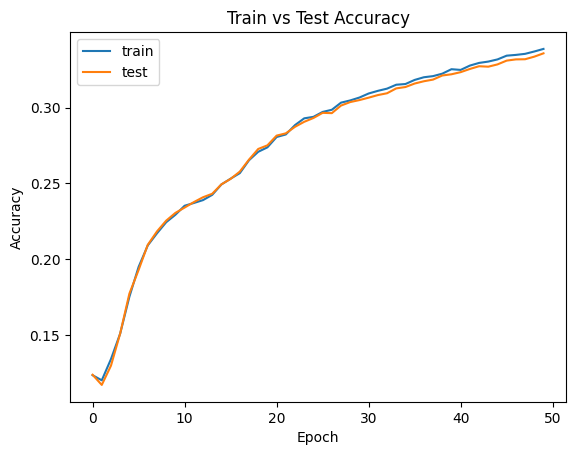

In [20]:
# 정확도 Plot
plot_acc(train_accs, test_accs)